In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace import sarimax
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime

In [65]:
df=pd.read_csv('train (1).csv',parse_dates=['Datetime'])
df.drop(['Sub_metering_1','Sub_metering_2','Sub_metering_3'],axis=1,inplace=True)
# df=df[['Datetime','Global_active_power']].set_index('Datetime')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26671 entries, 0 to 26670
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Datetime               26671 non-null  datetime64[ns]
 1   Global_reactive_power  26541 non-null  float64       
 2   Voltage                26541 non-null  float64       
 3   Global_intensity       26541 non-null  float64       
 4   Global_active_power    26671 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.0 MB
None


,Datetime,Global_reactive_power,Voltage,Global_intensity,Global_active_power
0,2006-12-16 17:00:00,0.229000,234.643889,18.100000,4.222889
1,2006-12-16 18:00:00,0.080033,234.580167,15.600000,3.632200
2,2006-12-16 19:00:00,0.085233,233.232500,14.503333,3.400233
3,2006-12-16 20:00:00,0.075100,234.071500,13.916667,3.268567
4,2006-12-16 21:00:00,0.076667,237.158667,13.046667,3.056467


In [73]:
df.tail()

,Datetime,Global_reactive_power,Voltage,Global_intensity,Global_active_power
26666,2009-12-31 19:00:00,0.186967,237.248333,12.846667,3.062867
26667,2009-12-31 20:00:00,0.158767,237.794500,11.900000,2.842500
26668,2009-12-31 21:00:00,0.215600,236.641500,12.100000,2.875367
26669,2009-12-31 22:00:00,0.134800,237.913833,8.520000,2.034367
26670,2009-12-31 23:00:00,0.098700,240.071333,6.956667,1.690500


In [67]:
print(df.shape)
print(df.isnull().sum())
df.dropna(inplace=True)
print(df.isnull().sum())

(26671, 5)
Datetime                   0
Global_reactive_power    130
Voltage                  130
Global_intensity         130
Global_active_power        0
dtype: int64
Datetime                 0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Global_active_power      0
dtype: int64


<Axes: >

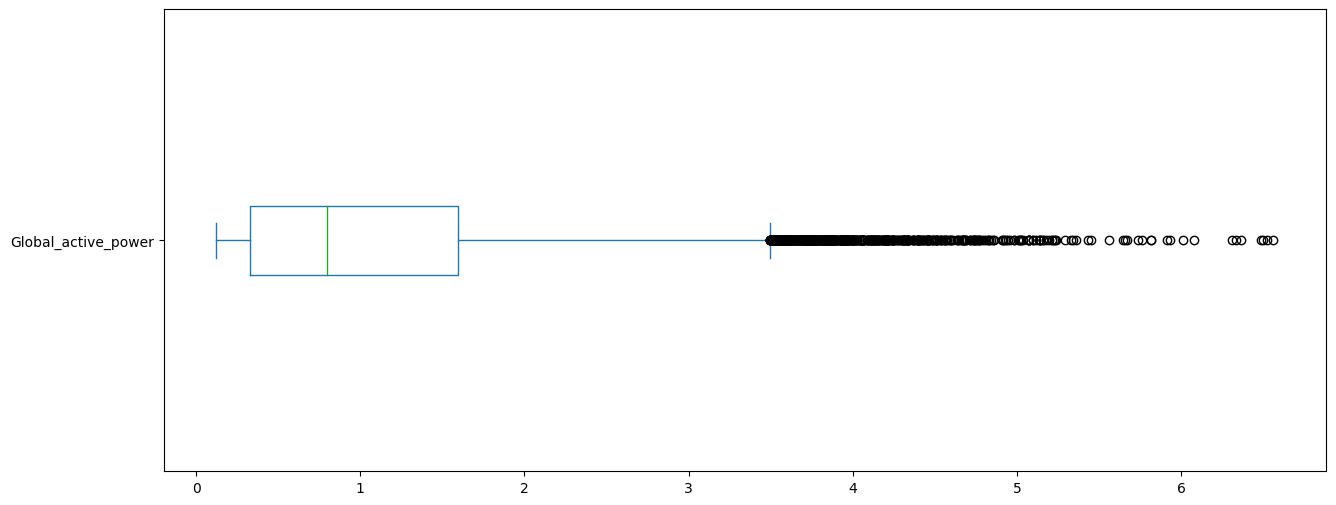

In [30]:
fig,ax=plt.subplots(figsize=(15,6))
df['Global_active_power'].plot(kind='box',vert=False,ax=ax)

<Axes: xlabel='Datetime'>

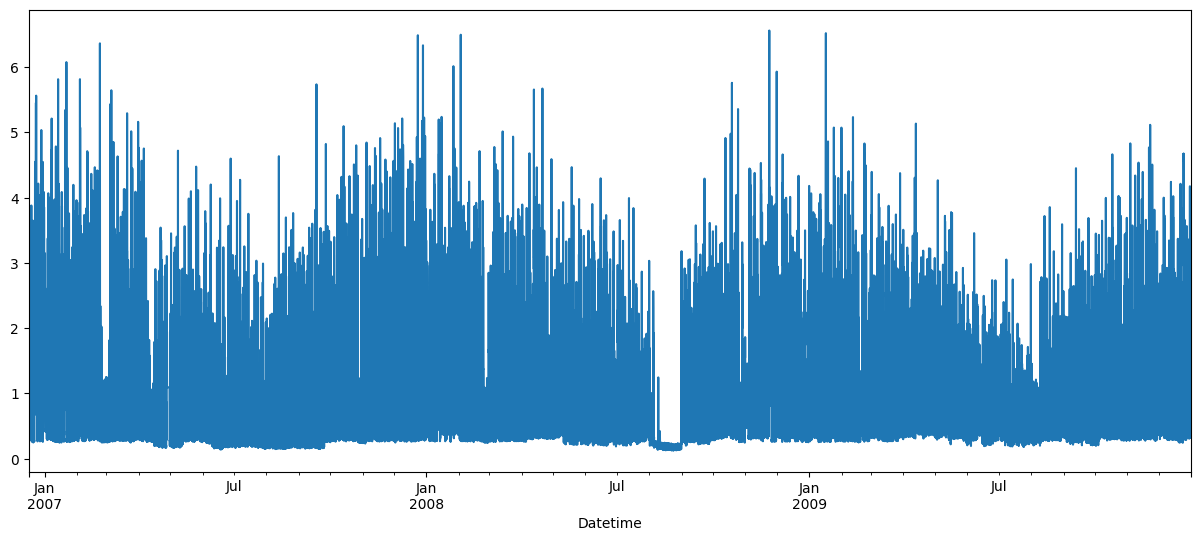

In [6]:
fig,ax=plt.subplots(figsize=(15,6))
df['Global_active_power'].plot(ax=ax)

<Axes: xlabel='Datetime'>

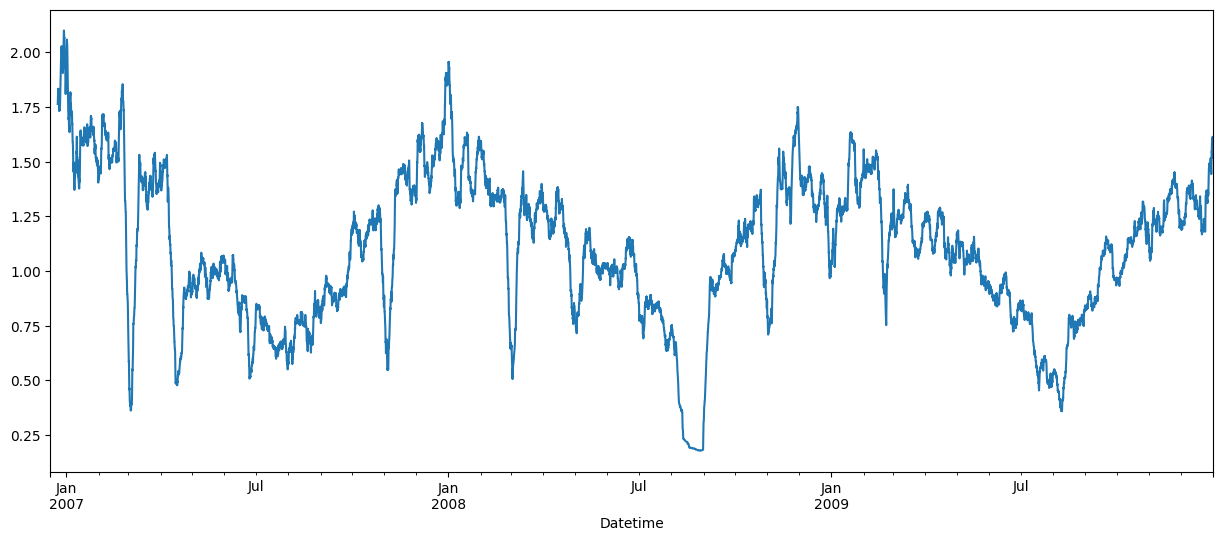

In [7]:
fig,ax=plt.subplots(figsize=(15,6))
df['Global_active_power'].rolling(168).mean().plot(ax=ax)

In [8]:
df['Global_active_power.L1']=df['Global_active_power'].shift(1)

In [9]:
df.dropna(axis=0,inplace=True)
df.shape

(26670, 2)

In [10]:
dff=df[['Global_active_power.L1','Global_active_power']]

In [11]:
dff.corr()

,Global_active_power.L1,Global_active_power
Global_active_power.L1,1.000000,0.719184
Global_active_power,0.719184,1.000000


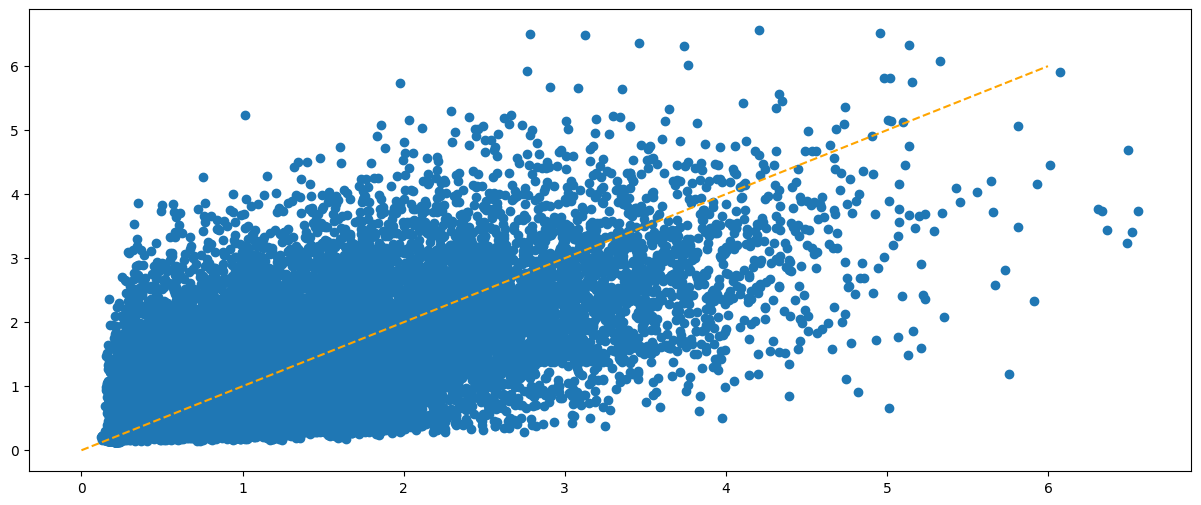

In [12]:
fig,ax=plt.subplots(figsize=(15,6))
ax.scatter(x=df['Global_active_power.L1'],y=df['Global_active_power'])
ax.plot([0,6],[0,6],linestyle='--',color='orange')

In [68]:
target='Global_active_power'
y=df[target]
X=df.drop(target,axis=1)

In [69]:
cuttoff=int(len(X)*0.8)
X_train, y_train = X.iloc[:cuttoff],y.iloc[:cuttoff]
X_test, y_test = X.iloc[cuttoff:],y.iloc[cuttoff:]

In [70]:
print(len(X_train))
print(len(X_test))
len(X_train)+len(X_test)==len(X)

21232
5309


True

In [71]:
y_pred_baseline = [y_train.mean()]*len(y_train)
mae_baseline = mean_absolute_error(y_pred_baseline,y_train)

print("Mean Global active power Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean Global active power Reading: 1.13
Baseline MAE: 0.77


In [72]:
model=LinearRegression()
model.fit(X_train,y_train)

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>)

In [36]:
train_mae=mean_absolute_error(model.predict(X_train),y_train)
test_mae=mean_absolute_error(model.predict(X_test),y_test)
print(train_mae)
print(test_mae)

0.017454757633208563
0.017184215459330313


In [37]:
intercept = model.intercept_
coefficient = model.coef_

print(f"Global active power = {intercept} + ({coefficient} * Global_active_power.L1)")

Global active power = -1.0080485647185824 + ([-0.23220877  0.0042022   0.2407886 ] * Global_active_power.L1)


In [38]:
df_pred_test = pd.DataFrame({'y_test':y_test,
                           'y_pred':model.predict(X_test)})
df_pred_test.head()

,y_test,y_pred
Datetime,,
2009-05-21 23:00:00,0.464700,0.462556
2009-05-22 00:00:00,0.924867,0.907403
2009-05-22 01:00:00,0.436600,0.443977
2009-05-22 02:00:00,0.347967,0.353437
2009-05-22 03:00:00,0.439300,0.440517


In [39]:
fig = px.line(df_pred_test,labels={'value':'Global active power'})
fig.show()

In [43]:
y_pred=model.predict(X_train)
y_pred_test=model.predict(X_test)

In [42]:
# Assuming y_true contains the actual target values and y_pred contains the predicted values
mse = mean_squared_error(y_train, y_pred)
rmse = mean_squared_error(y_train, y_pred, squared=False)
mae = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)

MSE: 0.0006177268173256708
RMSE: 0.02485411067259641
MAE: 0.017454757633208563
R-squared: 0.9993229066288714


In [45]:
# Assuming y_true contains the actual target values and y_pred contains the predicted values
mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)

MSE: 0.0006316468702305359
RMSE: 0.025132585824593056
MAE: 0.017184215459330313
R-squared: 0.9990092807478309


In [ ]:
# set staring and ending prediction time
start_time = datetime.strptime("2010-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')
end_time   = datetime.strptime("2010-11-26 21:00:00", '%Y-%m-%d %H:%M:%S')

# Make prediction
preds_sarima = model.predict(start=start_time, end=end_time)

In [63]:
sub=pd.read_csv('sample_submission (1).csv',parse_dates=['Datetime'])['Datetime']
sub.head()

0   2010-01-01 00:00:00
1   2010-01-01 01:00:00
2   2010-01-01 02:00:00
3   2010-01-01 03:00:00
4   2010-01-01 04:00:00
Name: Datetime, dtype: datetime64[ns]

In [64]:
# Make prediction
sub_pred = model.predict(sub)

c:\Users\Basit Khan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



ValueError: Expected 2D array, got 1D array instead:
array=['2010-01-01T00:00:00.000000000' '2010-01-01T01:00:00.000000000'
 '2010-01-01T02:00:00.000000000' ... '2010-11-26T19:00:00.000000000'
 '2010-11-26T20:00:00.000000000' '2010-11-26T21:00:00.000000000'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.